In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from dataclasses import dataclass
import os
from StoSpecRep.waveletEPSD import CWTx
from StoSpecRep.utils import SpecBundle, EPSD_show
from StoSpecRep.console import console
from DL_recons_pckg.SpecRepMethod import SRM

2023-02-10 15:09:27.371210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib widget

In [4]:
plt.rcParams.update({
            "font.size": 9,
            "text.usetex": True,
            "font.family": "serif",
            "legend.fontsize": 'small',
            })

**A failed attempt to get data from url**

## pull up the test data and have a look

**Note:**

In this file, we test the EPSD procedures on the El centro earthquake signal.
Refer to the paper below for comparison of the results.

```
Liang, J., Chaudhuri, S.R. and Shinozuka, M., 2007. Simulation of nonstationary stochastic processes by spectral representation. Journal of Engineering Mechanics, 133(6), pp.616-627.
```


**what we found out**

- EPSD by `STFT` is 10 times larger than PSD by `Welch` with same *nperseg*

- EPSD by `Wavelet Transform` is even 3 times larger than EPSD by `STFT`


In [5]:
os.getcwd()

'/Users/lesliec/Documents/Github_repos/StoSpecRep/test'

In [6]:
NS_acc = np.loadtxt('test_data/elcentro_NS.txt')

In [7]:
NS_acc.shape

(2688, 2)

In [8]:
NS_acc[-1, 0]

53.74

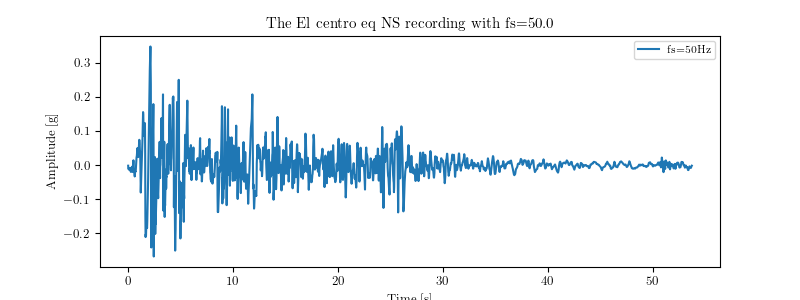

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(NS_acc[:, 0], NS_acc[:, 1], label='fs=50Hz')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [g]')
dt = NS_acc[100, 0] - NS_acc[99, 0]
ax.set_title(f"The El centro eq NS recording with fs={np.ceil(1/dt)}")
ax.legend()
plt.show()

In [10]:
# let's first create a signal object to facilate things

@dataclass
class Targetsignal:
    """ A temporary dataclass that represents the target signal """
    t_axis: float
    signal: float


In [11]:
El_centro = Targetsignal(NS_acc[:, 0], NS_acc[:, 1])

## We'll estimate the spectral representation, which includes:

- Power spectral density using `Welch`

- EPSD using both `STFT` and `Wavelet Transform`

### 1.  Global PSD estimate

In [12]:
NPERSEG = 256

f, Pxx = signal.welch(
    El_centro.signal,
    fs=50,
    window='hann',
    nperseg=NPERSEG, 
    scaling='density')

In [13]:
f_periodogram, Pxx_periodogram = signal.welch(
    El_centro.signal,
    fs=50,
    window='hann',
    nperseg=len(El_centro.signal), 
    scaling='density')

The PSD shape is: (129,)


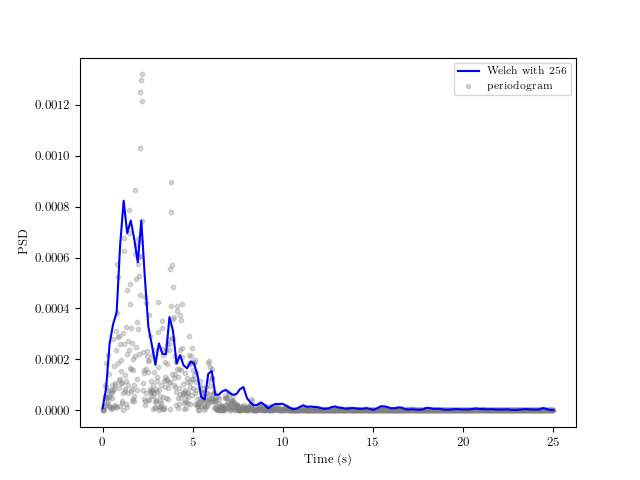

In [14]:
fig, ax = plt.subplots()
ax.plot(f, Pxx, '-b', label=f'Welch with {NPERSEG}')
ax.scatter(f_periodogram, Pxx_periodogram, s=10, color='gray', alpha=0.3, label='periodogram')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PSD')
ax.legend()
print("The PSD shape is:",Pxx.shape)

In [ ]:
# plt.close('all')

### 2.  Evolutionary EPSD estimate

In [15]:
f, t, Sxx = signal.spectrogram(
                El_centro.signal,
                fs=50,
                nperseg=NPERSEG,
                window='hann',
                mode='psd')

STFT_epsd_El = SpecBundle(epsd=Sxx, freq=f, t_axis=t)

In [16]:
print("The shape of EPSD by STFT:", STFT_epsd_El.epsd.shape)

The shape of EPSD by STFT: (129, 11)


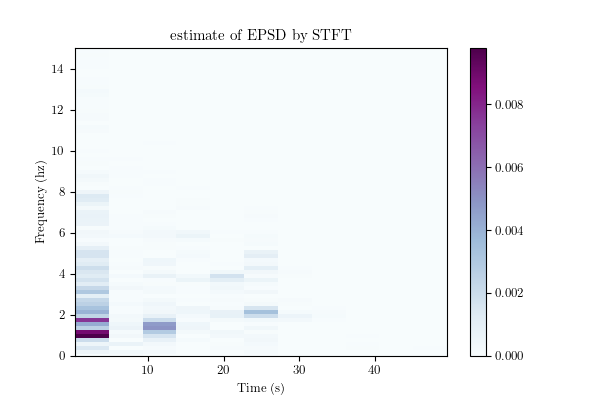

In [17]:
EPSD_show(*STFT_epsd_El, format='2d', title_name='estimate of EPSD by STFT')

Q:
    
- Why STFT spectrogram amplitude is 10 times larger than that of Welch

## create an `CWTx` object

In [18]:
Elcentro_obj = CWTx(signal=El_centro.signal, fs=50, t_axis=El_centro.t_axis)

In [19]:
Elcentro_obj.goto_scales

(a=2,b=10) ==> scales_range(4.0, 1024.0) ==> FreqRange(low=0.0396728515625, high=10.15625)

array([   4.        ,    4.8428693 ,    5.86334577,    7.09885432,
          8.59470592,   10.40575936,   12.59843315,   15.2531413 ,
         18.46724244,   22.35861039,   27.06995698,   32.77406593,
         39.68012946,   48.04142024,   58.16457984,   70.42086457,
         85.25976085,  103.22546966,  124.9768646 ,  151.31165532,
        183.19564272,  221.79813868,  268.53484936,  325.11979475,
        393.62816851,  476.57244361,  576.99451455,  698.57725575,
        845.77958706, 1024.        ])

In [20]:
Elcentro_obj.check_scales(a=1, b=8, num=900)

(a=1,b=8) ==> scales_range(2.0, 256.0) ==> FreqRange(low=0.15869140625, high=20.3125)

In [21]:
# propose scales to use
Elcentro_obj.propose_scales(a=1, b=8, num=900)

You've proposed scales:

(a=1,b=8) ==> scales_range(2.0, 256.0) ==> FreqRange(low=0.15869140625, high=20.3125)

In [22]:
# compute EPSD by wavelet transform
Elcentro_obj.computeEPSD()

Yo! Computing EPSD with the proposed scales

Swt shape: (900, 2688)

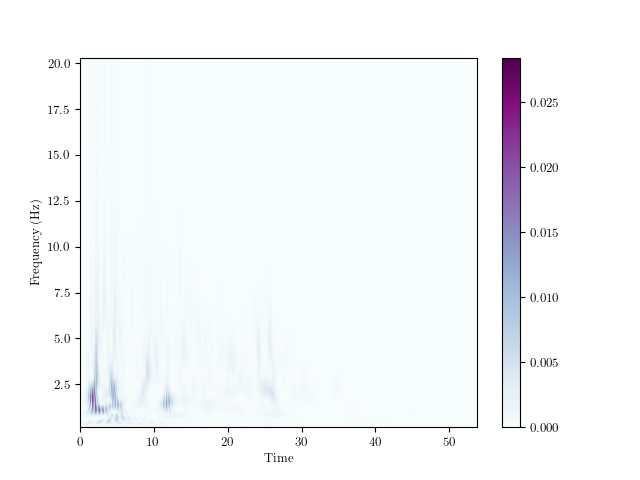

In [25]:
''' wavelet EPSD plot'''
# Currently not using this because the plot is too huge ... 
Elcentro_obj.plot_wavelet2dEPSD()
# plt.xlim(10, 15)

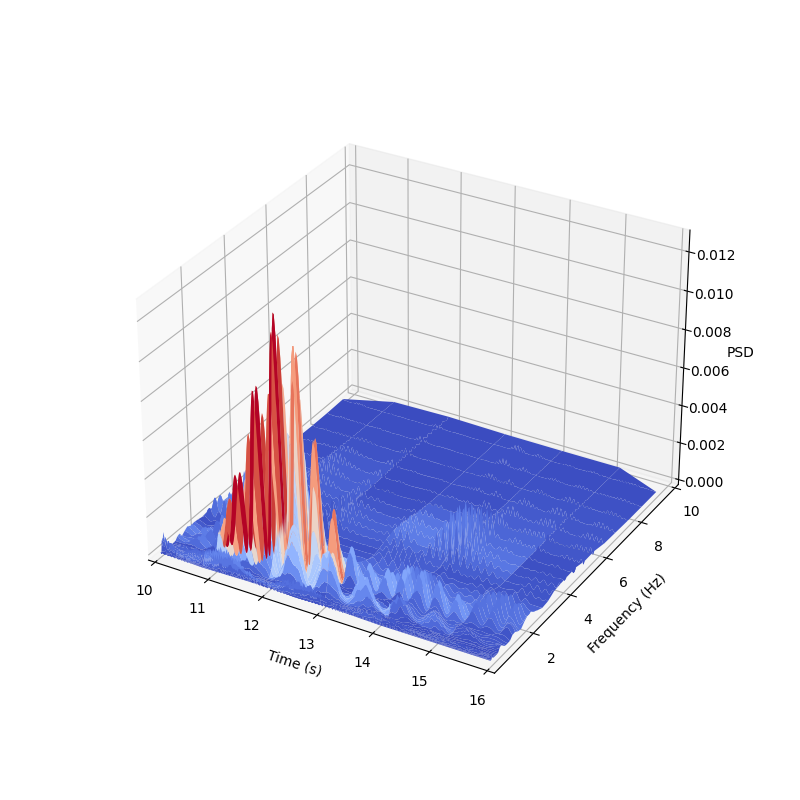

In [29]:
with plt.style.context('default'):
    Elcentro_obj.plot_3dEPSD(x_low=10, x_high=16, y_low=0.2, y_high=10)

#### shape understanding of the wavelet results (EPSD, f, t)

> EPSD

In [ ]:
Elcentro_obj._pwr_coef.shape

> frequency array

In [ ]:
len(Elcentro_obj._freqs)

> frequency resolution: $\Delta_{\omega}$

In [ ]:
# delta_f = np.append(arr=np.diff(freq_range),  values=np.diff(freq_range)[-1])

> time axis

In [ ]:
Elcentro_obj.t_axis.shape

#### See the EPSD

In [ ]:
Elcentro_obj.plot_waveletEPSD(option='2d')
plt.xlim(0, 30)
plt.ylim(0, 10)

In [ ]:
# fig=plt.figure()
Elcentro_obj.plot_3dEPSD(x_low=0, x_high=14, y_low=0, y_high=10)

#### Get the simulation

In [ ]:
# wavelet EPSD sample generations
wavelet_ensemble_simus = Elcentro_obj.g_ensemble_simus(200)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Elcentro_obj.t_axis, wavelet_ensemble_simus[11])
plt.show()

> back up the code cell below

In [ ]:
# # alright, let's write up a general function that takes (Stw, w, t) 
# def SRM_formula(Stw, f_vec, t_vec):
#     """ Redo the SRM based on a computed wavelet EPSD 
    
#     Hint: 
#     ----
#     Swt    --> obj._pwr_coef.shape
#     f_vec  --> obj._freqs
#     t_vec  --> obj.t_axis
#     """
    
#     # entry
#     N1 = len(f_vec)
#     w_vec = 2 * np.pi * f_vec
#     phi_n = np.random.uniform(0, 2 * np.pi, N1)
#     delta_f = np.abs(np.append(arr=np.diff(f_vec),  values=np.diff(f_vec)[-1]))
#     delta_w  = 2 * np.pi * delta_f
    
#     # main course
#     sum = 0
#     for i in range(1, N1):
#         sum = sum + np.sqrt(4 * Stw[i] * delta_w[i]) * np.cos(w_vec[i] * t_vec + phi_n[i])
#     return sum

# trial_simulation = SRM_formula(
#         Stw=Elcentro_obj._pwr_coef, 
#         f_vec=Elcentro_obj._freqs, 
#         t_vec=Elcentro_obj.t_axis)

**get a simulation**

In [ ]:
trial_simulation = Elcentro_obj.g_a_SRMsimu()

In [ ]:
fig, (ax0, ax1) =plt.subplots(nrows=2, ncols=1)

ax0.plot(NS_acc[:, 0], NS_acc[:, 1], label='ground truth')
ax0.legend()
ax1.plot(Elcentro_obj.t_axis, trial_simulation, color='purple', label='sample simulation')
ax1.legend()

**get an ensemble of simulations**

In [ ]:
ensemble_simus = Elcentro_obj.g_ensemble_simus(20)

In [ ]:
ensemble_simus.shape

In [ ]:
fig, (ax0, ax1, ax2, ax3) =plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

ax0.plot(NS_acc[:, 0], NS_acc[:, 1], label='ground truth')
ax0.legend()

ax1.plot(Elcentro_obj.t_axis, ensemble_simus[0], color='purple', label='sample simulation')
ax1.legend()
ax2.plot(Elcentro_obj.t_axis, ensemble_simus[3], color='purple', label='sample simulation')
ax2.legend()
ax3.plot(Elcentro_obj.t_axis, ensemble_simus[6], color='purple', label='sample simulation')
ax3.legend()
plt.show()

#### compute the PSA of the simulations

### okay, below it shows the old way ... something wrong with the it

In [ ]:
# maybe I can just pass along N

Elcentro_simu_obj = SRM(
        wu=(50/2)*2*np.pi, 
        N1=50, 
        fs=50, 
        duration=50)

In [ ]:
console.print(Elcentro_simu_obj)

In [ ]:
raw_esmble_gens2_wavelet =  Elcentro_simu_obj.nonsta_esmb_simus(
        Pxx=Elcentro_obj._pwr_coef, 
        freqs=Elcentro_obj._freqs, 
        t_bins=Elcentro_obj.t_axis, 
        ensemble_num=50)

In [ ]:
len(raw_esmble_gens2_wavelet[0])

In [ ]:
plt.close('all')

In [ ]:
fig, (ax0, ax1) =plt.subplots(nrows=2, ncols=1)

ax0.plot(NS_acc[:, 0], NS_acc[:, 1])
ax1.plot(Elcentro_obj.t_axis[:2500], raw_esmble_gens2_wavelet[1])

In [ ]:
# dig into details ...
interpolated_Swt = Elcentro_simu_obj._interpo_spectra(
        Pxx=Elcentro_obj._pwr_coef, 
        freqs=Elcentro_obj._freqs, 
        t_bins=Elcentro_obj.t_axis)

In [ ]:
interpolated_Swt.shape